# Figure 5

This notebook recreates Figure 5 from the original publication, applying LERM to ice cores over the Holocene.

In [1]:
import pickle
import random

import pyleoclim as pyleo
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import ammonyte as amt
from tqdm import tqdm

from pylipd.lipd import LiPD

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#We suppress warnings for these notebooks for presentation purposes. Best practice is to not do this though.
import warnings
warnings.filterwarnings('ignore')

Analysis here is largely identical to that for Figures 2 and 3, though we use slightly different parameters.

In [3]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

In [4]:
color_list = sns.color_palette('colorblind')

Here we load the data using [pyLiPD](https://github.com/LinkedEarth/pylipd).

In [5]:
lipd_path = '../data/8k_ice'

all_files = LiPD()

if __name__=='__main__':
    all_files.load_from_dir(lipd_path,parallel=True)

record_names = all_files.get_all_dataset_names()

Loading 8 LiPD files


  0%|                                                                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]

/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/alexjames/miniconda3/envs/ammonyte/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/alexjames/miniconda3/envs/amm

 12%|██████████████████████████                                                                                                                                                                                      | 1/8 [00:00<00:02,  2.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 18.19it/s]

Loaded..


In [6]:
series_list = []

# We specify the indices of interest in each dataframe by hand here

index_dict = {
    'GRIP.GRIP.1992' : 'd18O',
    'Renland.Johnsen.1992' : 'd18O',
    'EDML.Stenni.2010' : 'bagd18O',
    'EPICADomeC.Stenni.2010' : 'bagd18O',
    'Vostok.Vimeux.2002' : 'temperature',
    'GISP2.Grootes.1997' : 'd18O',
    'NGRIP.NGRIP.2004' : 'd18O',
    'TALDICE.Mezgec.2017' : 'd18O',
}

for record in record_names:
    d = LiPD()
    d.load(f'{lipd_path}/{record}.lpd')
    df = d.get_timeseries_essentials()
    row = df[df['paleoData_variableName']==index_dict[record]][df['time_variableName']=='age']
    lat = row['geo_meanLat'].to_numpy()[0]
    lon = row['geo_meanLon'].to_numpy()[0]
    elevation = row['geo_meanElev'].to_numpy()[0]
    value = row['paleoData_values'].to_numpy()[0]
    value_name = row['paleoData_variableName'].to_numpy()[0]
    value_unit = row['paleoData_units'].to_numpy()[0]
    time = row['time_values'].to_numpy()[0]
    time_unit = row['time_units'].to_numpy()[0]
    time_name = row['time_variableName'].to_numpy()[0]
    label = row['dataSetName'].to_numpy()[0]
    geo_series = pyleo.GeoSeries(time=time,
                                 value=value,
                                 lat=lat,
                                 lon=lon,
                                 elevation=elevation,
                                 time_unit=time_unit,
                                 time_name=time_name,
                                 value_name=value_name,
                                 value_unit=value_unit,
                                 label=label,
                                 archiveType='ice')
    series_list.append(geo_series)

geo_ms = pyleo.MultipleGeoSeries(series_list)

Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 85.03it/s]

Loaded..
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.11it/s]

Loaded..
NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.97it/s]

Loaded..


NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.60it/s]

Loaded..


Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.62it/s]

Loaded..


NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.69it/s]

Loaded..
NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.85it/s]

Loaded..


NaNs have been detected and dropped.
Time axis values sorted in ascending order
Loading 1 LiPD files


  0%|                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]

Loaded..


Time axis values sorted in ascending order


In [7]:
greenland_ms_list = []
antarctica_ms_list = []

for series in geo_ms.series_list:
    if series.lat > 0 or series.label == 'EPICADomeC.Stenni.2010':
        series.time_unit = 'Years BP'
        greenland_ms_list.append(series)
    else:
        series.time_unit = 'Years BP'
        antarctica_ms_list.append(series)

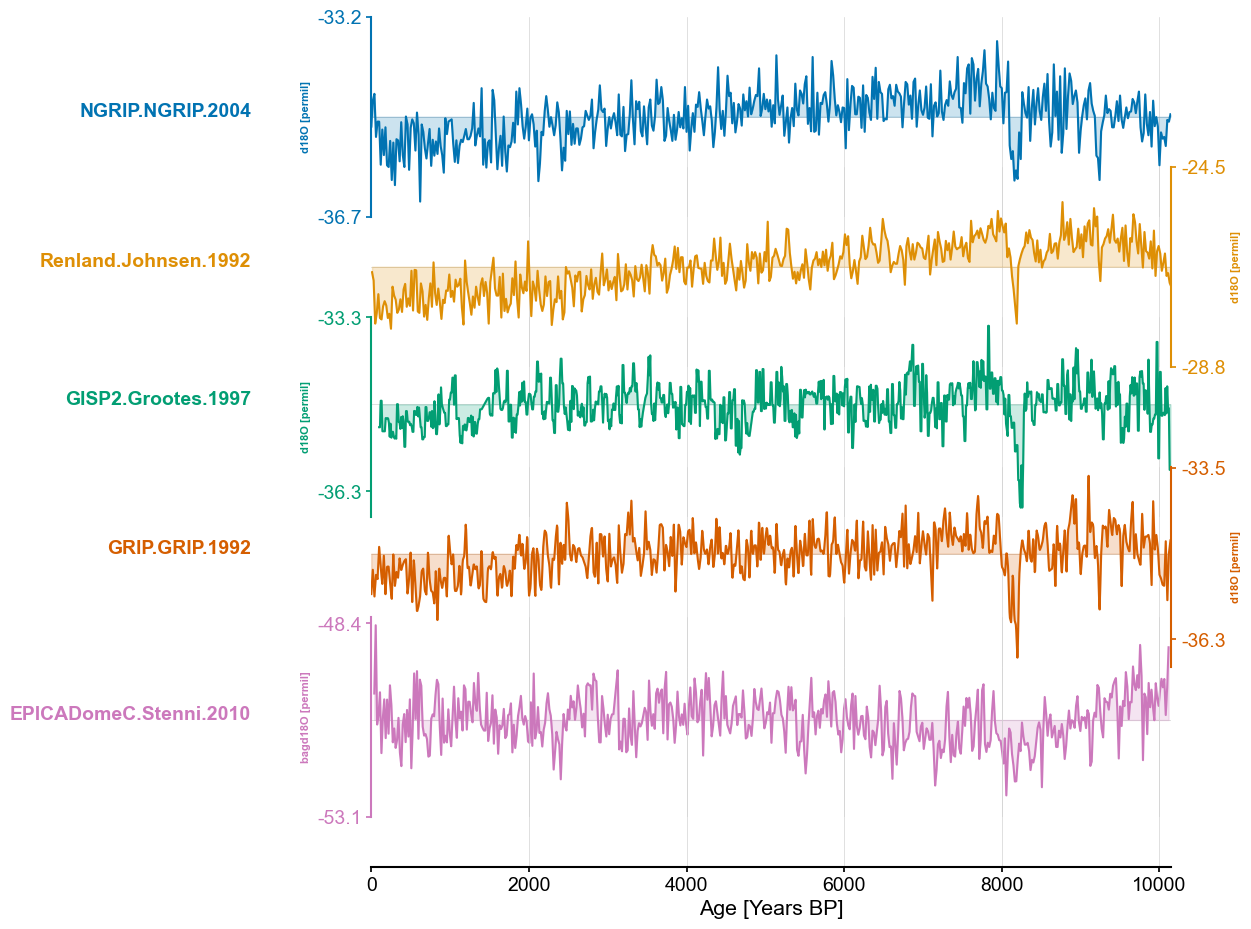

In [8]:
end_time=10150

greenland_ms = pyleo.MultipleSeries([series.slice((0,end_time)).interp() for series in greenland_ms_list])
greenland_ms.stackplot(colors=color_list[:len(greenland_ms.series_list)],figsize=(8,10))

ms_dict = {series.label:series for series in greenland_ms.series_list}

In [9]:
lp_series_dict = {}
m = 12
tau = 4

for idx,series in enumerate(greenland_ms.series_list):
    if series.label != 'EPICADomeC.Stenni.2010':
        amt_series = amt.Series(
            time=series.time,
            value=series.value,
            time_name = series.time_name,
            value_name = series.value_name,
            time_unit = series.time_unit,
            value_unit = series.value_unit,
            label = series.label,
            clean_ts=False,
            sort_ts=None
        ).convert_time_unit('Years').detrend(method='savitzky-golay')
    else:
        amt_series = amt.Series(
            time=series.time,
            value=series.value,
            time_name = series.time_name,
            value_name = series.value_name,
            time_unit = series.time_unit,
            value_unit = series.value_unit,
            label = series.label,
            clean_ts=False,
            sort_ts=None
        ).convert_time_unit('Years')
    td = amt_series.embed(m,tau)
    print(f'{series.label} Tau is: {td.tau}')
    eps = td.find_epsilon(eps=1,target_density=.05,tolerance=.01)
    rm = eps['Output']
    lp = rm.laplacian_eigenmaps(w_size=20,w_incre=4).convert_time_unit('Years BP')
    lp_series_dict[series.label] = lp

NGRIP.NGRIP.2004 Tau is: 4
Initial density is 0.0216
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0216
Epsilon: 1.1420, Density: 0.0584
Epsilon: 1.1420, Density: 0.0584.


Renland.Johnsen.1992 Tau is: 4
Initial density is 0.0420
Initial density is within the tolerance window!


GISP2.Grootes.1997 Tau is: 4
Initial density is 0.0263
Initial density is not within the tolerance window, searching...
Epsilon: 1.0000, Density: 0.0263
Epsilon: 1.1186, Density: 0.0604
Epsilon: 1.1186, Density: 0.0604
Epsilon: 1.0669, Density: 0.0429
Epsilon: 1.0669, Density: 0.0429.


GRIP.GRIP.1992 Tau is: 4
Initial density is 0.1633
Initial density is not within the tolerance window, searching...
Epsilon: 0.0000, Density: 0.0000
Epsilon: 0.5000, Density: 0.0026
Epsilon: 0.5000, Density: 0.0026
Epsilon: 0.7372, Density: 0.0247
Epsilon: 0.7372, Density: 0.0247
Epsilon: 0.8636, Density: 0.0701
Epsilon: 0.8636, Density: 0.0701
Epsilon: 0.7629, Density: 0.0313
Epsilon: 0.7629, Density: 0.0313
Epsilon: 0.8565, Density: 0.0667
Epsilon: 0.8565, Density: 0.0667
Epsilon: 0.7733, Density: 0.0342


Epsilon: 0.7733, Density: 0.0342
Epsilon: 0.8524, Density: 0.0646
Epsilon: 0.8524, Density: 0.0646
Epsilon: 0.7794, Density: 0.0361
Epsilon: 0.7794, Density: 0.0361
Epsilon: 0.8490, Density: 0.0630
Epsilon: 0.8490, Density: 0.0630
Epsilon: 0.7840, Density: 0.0375
Epsilon: 0.7840, Density: 0.0375
Epsilon: 0.8464, Density: 0.0618
Epsilon: 0.8464, Density: 0.0618
Epsilon: 0.7875, Density: 0.0387
Epsilon: 0.7875, Density: 0.0387
Epsilon: 0.8441, Density: 0.0607
Epsilon: 0.8441, Density: 0.0607


Epsilon: 0.7905, Density: 0.0397
Epsilon: 0.7905, Density: 0.0397
Epsilon: 0.8421, Density: 0.0599
Epsilon: 0.8421, Density: 0.0599.


EPICADomeC.Stenni.2010 Tau is: 4
Initial density is 0.0022
Initial density is not within the tolerance window, searching...
Epsilon: 1.4777, Density: 0.0132
Epsilon: 1.8460, Density: 0.0653
Epsilon: 1.6933, Density: 0.0352
Epsilon: 1.8410, Density: 0.0639
Epsilon: 1.7022, Density: 0.0365
Epsilon: 1.8369, Density: 0.0630
Epsilon: 1.7068, Density: 0.0372
Epsilon: 1.8347, Density: 0.0625
Epsilon: 1.7096, Density: 0.0378
Epsilon: 1.8319, Density: 0.0618
Epsilon: 1.7144, Density: 0.0385
Epsilon: 1.8298, Density: 0.0612
Epsilon: 1.7174, Density: 0.0389
Epsilon: 1.8288, Density: 0.0610
Epsilon: 1.7186, Density: 0.0391
Epsilon: 1.8278, Density: 0.0609
Epsilon: 1.7193, Density: 0.0392
Epsilon: 1.8273, Density: 0.0608
Epsilon: 1.7197, Density: 0.0393


Epsilon: 1.8270, Density: 0.0607
Epsilon: 1.7200, Density: 0.0393
Epsilon: 1.8269, Density: 0.0607
Epsilon: 1.8269, Density: 0.0607
Epsilon: 1.7734, Density: 0.0491
Epsilon: 1.7734, Density: 0.0491.


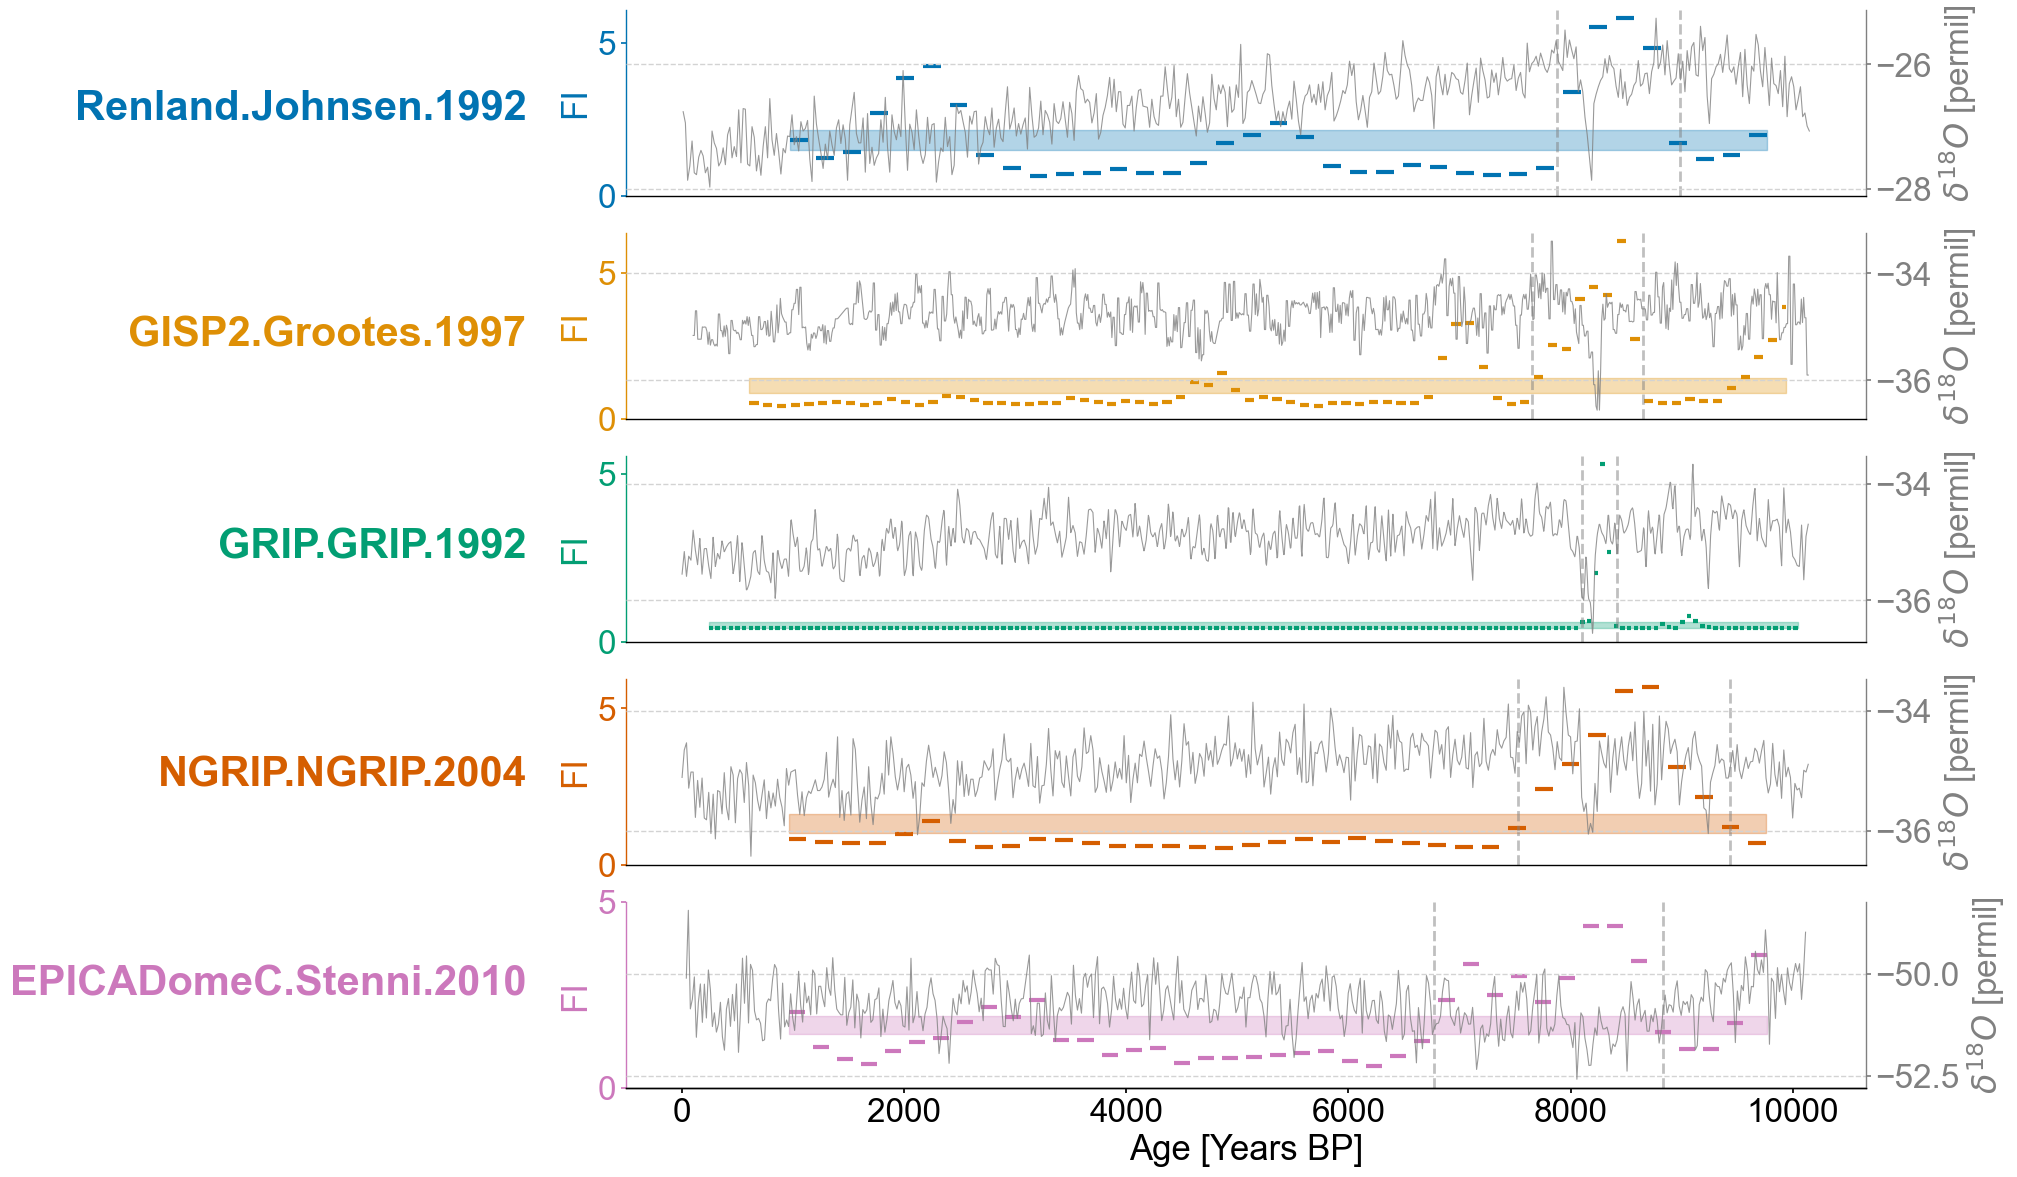

In [10]:
ms = greenland_ms

ordered_list = [
    'Renland.Johnsen.1992',
    'GISP2.Grootes.1997',
    'GRIP.GRIP.1992',
    'NGRIP.NGRIP.2004',
    'EPICADomeC.Stenni.2010'
]

SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(ordered_list),ncols=1,sharex=True,figsize=(16,14))
transition_timing = []

for idx,record in enumerate(ordered_list):
    ts = lp_series_dict[record]
    ts.value_name = 'FI'
    ts.value_unit = None

    ax = axes[idx]
    ts_smooth = amt.utils.fisher.smooth_series(series=ts,block_size=3) #Using a block size of 3 for smoothing the Fisher information
    upper, lower = amt.utils.sampling.confidence_interval(series=ts,upper=95,lower=5,w=50,n_samples=10000) #Calculating the bounds for our confidence interval using default values 
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))
    transition_timing=[]
    
    for transition in transitions:
        if ts.label == "GISP2.Grootes.1997":
            if transition > 7500 and transition < 9000:
                transition_timing.append(transition)
        elif ts.label == "GRIP.GRIP.1992":
            if transition > 7500 and transition < 8700:
                transition_timing.append(transition)
        elif ts.label == "EPICADomeC.Stenni.2010":
            if transition > 6500 and transition < 9400:
                transition_timing.append(transition)
        elif ts.label == "NGRIP.NGRIP.2004":
            if transition > 6500:
                transition_timing.append(transition)
        else:
            if transition > 6200 and transition < 10000:
                transition_timing.append(transition)
    ts.confidence_smooth_plot(
        ax=ax,
        background_series = ms_dict[record].slice((0,end_time)),
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})
    
    for transition in transition_timing:
        ax.axvline(transition,color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = ts.label, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=30)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(lp_series_dict.keys())-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))